### Testing within-subject models

Issues need to be solved:
* Add more than $v$ to the model;
* Stim-coding with HDDMRegression (there was a tutorial on this)
* Flexible design

In [1]:
# check which python is in use.
import sys
print('Notebook is running:', sys.executable)

# further check your python version
from platform import python_version

print('The current HDDM version is', python_version())

# If you are sure that conda is installed, also check the package that install
#!conda list  # list the conda

import hddm, IPython
import numpy as np
import pandas as pd
print('The current HDDM version is', hddm.__version__) # 0.8.0

# Warning:`IPython.parallel` package has been deprecated since IPython 4.0. 
print('The current IPython version is', IPython.__version__) 

print('The current Numpy version is', np.__version__) 

print('The current Pandas version is', pd.__version__)

Notebook is running: /opt/conda/bin/python
The current HDDM version is 3.7.6
The current HDDM version is 0.8.0
The current IPython version is 7.15.0
The current Numpy version is 1.19.1
The current Pandas version is 1.0.5


/opt/conda/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
%matplotlib inline

# Preparation
import os, time, csv
from datetime import date
import random

import kabuki, hddm
from patsy import dmatrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Let's first replicate the tutorial on HDDM website

http://ski.clps.brown.edu/hddm_docs/tutorial_regression_stimcoding.html

In [3]:
#import sys
# the following will save all the stdout to the txt file, which is not necessary
# sys.stdout = open('ModelRecoveryOutput.txt', 'w')

### Creating simulated data for  the experiment

set number of subjects and number of trials per level for the simulated experiment

In [4]:
n_subjects = 10
trials_per_level = 150

Next, set up parameters of the DDM for three levels and the first stimulus. 

In [5]:
level1a = {'v':.3, 'a':2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
level2a = {'v':.4, 'a':2, 't':.3, 'sv':0, 'z':.6, 'sz':0, 'st':0}
level3a = {'v':.5, 'a':2, 't':.3, 'sv':0, 'z':.7, 'sz':0, 'st':0}

Next, set up parameters for the second stimulus, where `v` is the same as for the first stimulus. This is different for `z`. In particular: `z(stimulus_b) = 1 - z(stimulus_a)`. 

In [6]:
level1b = {'v':.3, 'a':2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
level2b = {'v':.4, 'a':2, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}
level3b = {'v':.5, 'a':2, 't':.3, 'sv':0, 'z':.3, 'sz':0, 'st':0}

Now, let's generate data for both stimuli

In [7]:
random.seed(123)
np.random.seed(123)
data_a, params_a = hddm.generate.gen_rand_data({'level1': level1a,
                                                'level2': level2a,
                                                'level3': level3a},
                                              size=trials_per_level,
                                              subjs=n_subjects)

data_b, params_b = hddm.generate.gen_rand_data({'level1': level1b,
                                                'level2': level2b,
                                                'level3': level3b},
                                              size=trials_per_level,
                                              subjs=n_subjects)

In [8]:
data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)
data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*2, index=data_a.index)
mydata = data_a.append(data_b,ignore_index=True)

In [ ]:
mydata.head(10)

### Setting up the HDDM regression model

The parameter `z` is bound between `0` and `1`, but the standard linear regression does not generate values between `0` and `1`. Therefore, we use a link-function, here the inverse logit $1/(1+exp(-x))$, which transform values between plus and minus infinity into values ranging from (just above) `0` to (nearly) `1`. [this link function is related to logistic regression].

Next, we need to ensure that bias is $z$ for one stimulus and $1-z$ for the other stimulus. To achive this, we can simply multiply the regression output for one stimulus with $-1$. This is implemented here by dot-multiplying the regression output "x" (which is an array) with equally sized array "stim", which is 1 for all stimulus A trials and -1 for stimulus B trials. We use the `patsy` command `dmatrix` to generate such an array from the stimulus column of our stimulated data.

**Note**
* dot-multiplying is vague here, it should be Hadamard Product, see [here](https://www.tutorialexample.com/understand-numpy-np-multiply-np-dot-and-operation-a-beginner-guide-numpy-tutorial/).

In [ ]:
tmpdata = mydata[mydata['subj_idx'] <= 0]
tmpdata

In [ ]:
stim = (dmatrix('0 + C(s, [[1], [-1]])', 
                {'s':tmpdata.stimulus.loc[tmpdata.index]},
                return_type="dataframe")
        )

#tmp = np.multiply(tmpdata[['stimulus']], stim[:])
tmp = np.multiply(tmpdata.stimulus.loc[tmpdata.index].to_frame(),stim)
#1/(1+np.exp(-((np.asarray(mydata.stimulus.iloc[mydata.index])) * stim)))
type(stim)
#stim.index
#type(mydata.stimulus.iloc[mydata.index])

In [ ]:
tmp

In [ ]:
tmp2 = tmpdata.stimulus.loc[tmpdata.index]
tmp2.to_frame().shape

In [9]:
# x is a pandas Series, it should be converted to dataframe to do the multiplication.

def z_link_func(x, data=mydata):
    stim = (dmatrix('0 + C(s, [[1], [-1]])',
                    {'s':data.stimulus.loc[x.index]},
                    return_type="dataframe")
#    stim = (np.asarray(dmatrix('0 + C(s, [[1], [-1]])',
                               #{'s':data.stimulus.ix[x.index]})) # original .ix is deprecated.
           )
    #print(x.shape)
    return 1/(1+np.exp(-np.multiply(x.to_frame(), stim)))
    #return 1 /( 1+np.exp(-(x * stim)))

Now, we set up the regression models for `z` and `v` and also include the link functions. The relevant string here used by `patsy` is `1 + C(condition)`. This will generate a design matrix with an intercept (that's what the `1` is for) and two dummy variables for remaining levels. (The column in which the levels are coded has the default name `condition`):

In [10]:
z_reg = {'model': 'z ~ 1 + C(condition)', 'link_func':z_link_func}

For `v` the link function is simply $x = x$, b/c no transformation is needed. (However, you could also analyze this experiment with response coded data. Then you would not stimulus code `z` but `v` and you would have to multiply the `v` for one condition with `-1`, with a link function like the one for `z`, but without the additional logit transform):

In [11]:
v_reg = {'model': 'v ~ 1 + C(condition)', 'link_func': lambda x:x}

Now, we can finally put the regression description for the hddm model together. The general for this is `[{'model': 'outcome_parameter ~ patsy_design_string', 'link_func': your_link_func}, {...}, ...]`

In [12]:
reg_descr = [z_reg, v_reg]

The last step before running the model is to construct the complete hddm regression model by adding data etc.

In [13]:
m_reg = hddm.HDDMRegressor(mydata, reg_descr, include='z')

Now, we start the sampling, which takes a long time

In [14]:
m_reg.sample(5000, burn=200, dbname='within_effect.db', db='pickle') 

In [ ]:
m_reg.save('within_effect')

### Comparing generative and recovered model parameters
First, let's print the model stats

In [16]:
m_reg.print_stats()

## Working with real data

Now let's move to the real data

In [4]:
# load data
df1a = hddm.load_csv('df1a.v.hddm_stim.csv')
df = df1a

# randomly chose 10 participants from the dataset
df_subj = df['subj_idx'].unique()
random.seed(10)
df_test_list = []
for i in range(10):
    pos = random.randint(0, (len(df_subj)-1))
    df_test_list.append(df_subj[pos])  

df_test = df[df['subj_idx'].isin(df_test_list)]

In [5]:
df_test.head(10)

,subj_idx,match,val,stim,response,rt
0,1001,Match,Bad,1,1,0.495
1,1001,Match,Bad,1,0,0.991
2,1001,Mismatch,Bad,0,1,0.704
3,1001,Match,Neutral,1,1,1.016
4,1001,Mismatch,Good,0,0,0.865
5,1001,Match,Good,1,1,1.049
6,1001,Match,Neutral,1,0,0.817
7,1001,Match,Good,1,1,0.865
8,1001,Mismatch,Bad,0,0,1.065
9,1001,Match,Neutral,1,1,0.953


In [16]:
# create a link func for z
def z_link_func(x, data=df_test):
    stim = (dmatrix('0 + C(s, [[1], [-1]])',
                    {'s':data.stim.loc[x.index]},
                    return_type="dataframe")
           )
    return 1/(1+np.exp(-np.multiply(x.to_frame(), stim)))

In [14]:
z_reg = {'model': 'z ~ 1 + match*val', 'link_func': z_link_func}

In [13]:
dmatrix('0 + match * val', {'match':df_test['match'], 'val':df_test['val']})

DesignMatrix with shape (3412, 6)
  Columns:
    ['match[Match]',
     'match[Mismatch]',
     'val[T.Good]',
     'val[T.Neutral]',
     'match[T.Mismatch]:val[T.Good]',
     'match[T.Mismatch]:val[T.Neutral]']
  Terms:
    'match' (columns 0:2)
    'val' (columns 2:4)
    'match:val' (columns 4:6)
  (to view full data, use np.asarray(this_obj))

In [17]:
z_reg = {'model': 'z ~ 1 + match*val', 'link_func': z_link_func}
v_reg = {'model': 'v ~ 1 + match*val', 'link_func': lambda x:x}
a_reg = {'model': 'a ~ 1 + match*val', 'link_func': lambda x:x}

reg_descr = [z_reg, v_reg, a_reg]

m_reg = hddm.HDDMRegressor(df_test, reg_descr, include='z')

Adding these covariates:
['z_Intercept', 'z_match[T.Mismatch]', 'z_val[T.Good]', 'z_val[T.Neutral]', 'z_match[T.Mismatch]:val[T.Good]', 'z_match[T.Mismatch]:val[T.Neutral]']
Adding these covariates:
['v_Intercept', 'v_match[T.Mismatch]', 'v_val[T.Good]', 'v_val[T.Neutral]', 'v_match[T.Mismatch]:val[T.Good]', 'v_match[T.Mismatch]:val[T.Neutral]']
Adding these covariates:
['a_Intercept', 'a_match[T.Mismatch]', 'a_val[T.Good]', 'a_val[T.Neutral]', 'a_match[T.Mismatch]:val[T.Good]', 'a_match[T.Mismatch]:val[T.Neutral]']


In [32]:
start_time = time.time()   # the start time of the processing

m_reg.sample(20000, burn=5000, dbname='df1_within_effect_try.db', db='pickle') 

print("\nRunning within model of exp 1a (10 subj) used: %f seconds" % (time.time() - start_time)) # print the elapse of time

 [-----------------100%-----------------] 20001 of 20000 complete in 72337.1 sec
Running within model of exp 1a (10 subj) used: 72337.430328 seconds


In [19]:
m_reg.save('df1_within_effect_try')

Plotting t
Plotting t_std
Plotting z_Intercept
Plotting z_Intercept_std
Plotting z_match[T.Mismatch]
Plotting z_val[T.Good]
Plotting z_val[T.Neutral]
Plotting z_match[T.Mismatch]:val[T.Good]
Plotting z_match[T.Mismatch]:val[T.Neutral]
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_match[T.Mismatch]
Plotting v_val[T.Good]
Plotting v_val[T.Neutral]
Plotting v_match[T.Mismatch]:val[T.Good]
Plotting v_match[T.Mismatch]:val[T.Neutral]
Plotting a_Intercept
Plotting a_Intercept_std
Plotting a_match[T.Mismatch]
Plotting a_val[T.Good]
Plotting a_val[T.Neutral]


/opt/conda/lib/python3.7/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting a_match[T.Mismatch]:val[T.Good]


/opt/conda/lib/python3.7/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting a_match[T.Mismatch]:val[T.Neutral]


/opt/conda/lib/python3.7/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


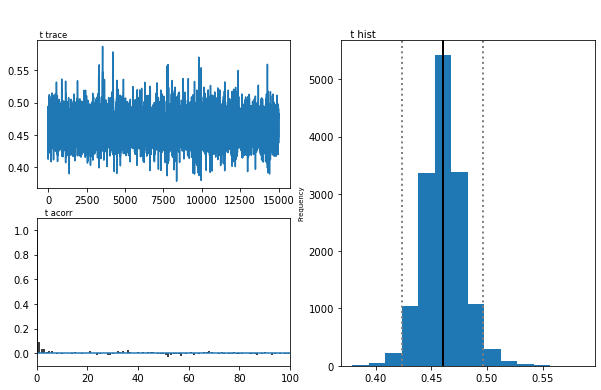

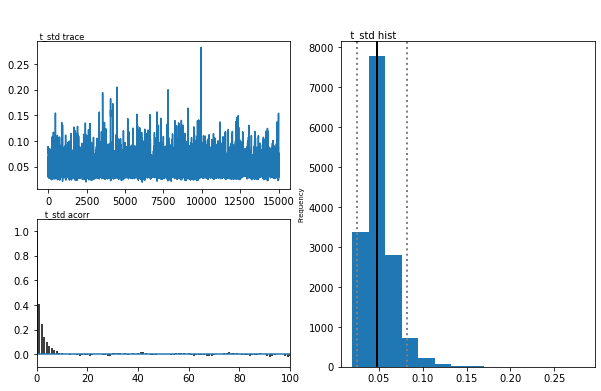

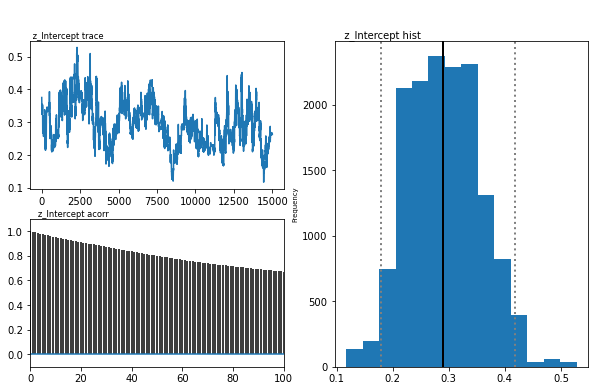

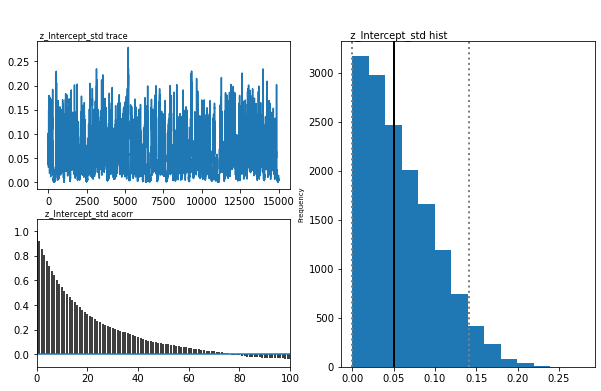

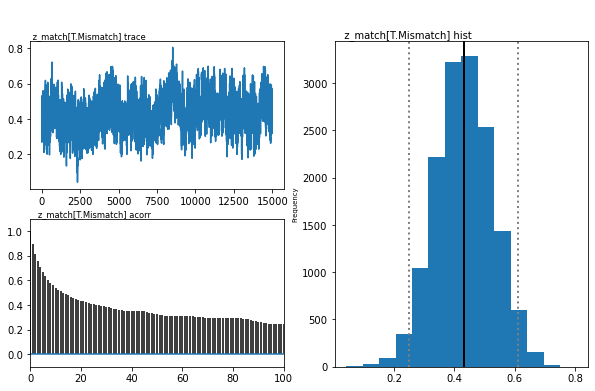

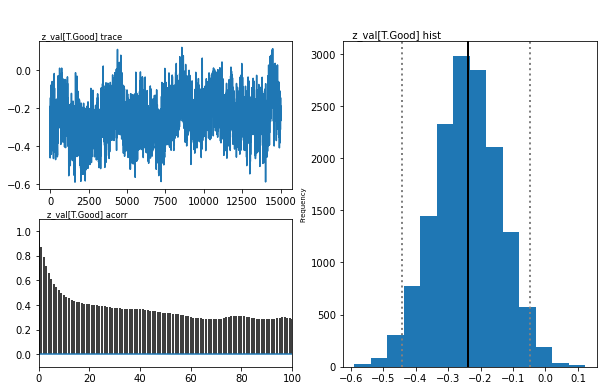

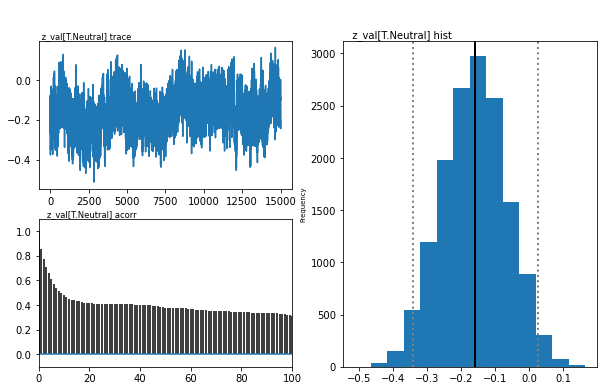

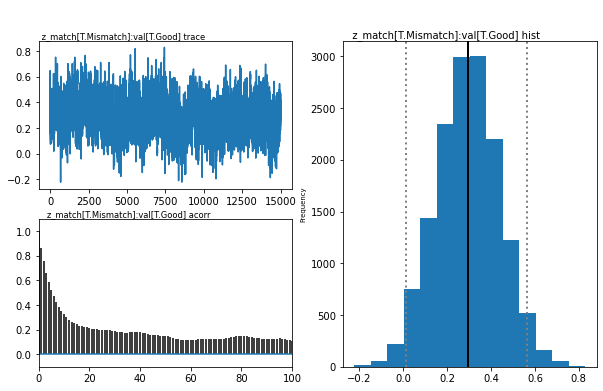

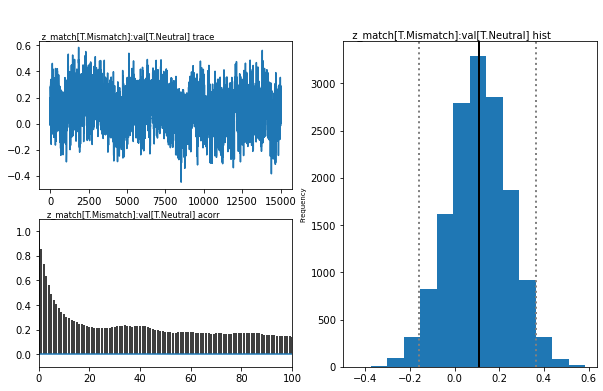

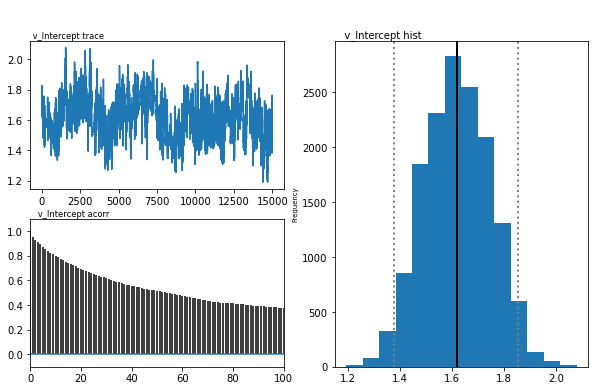

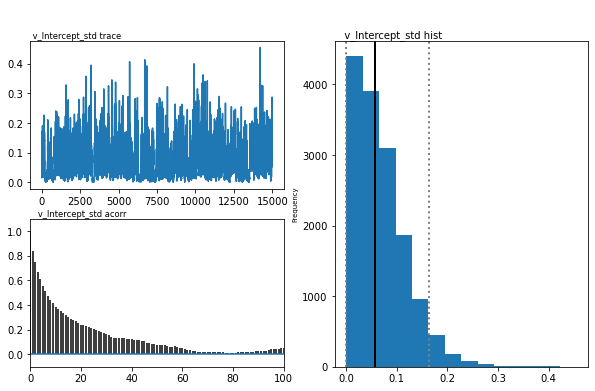

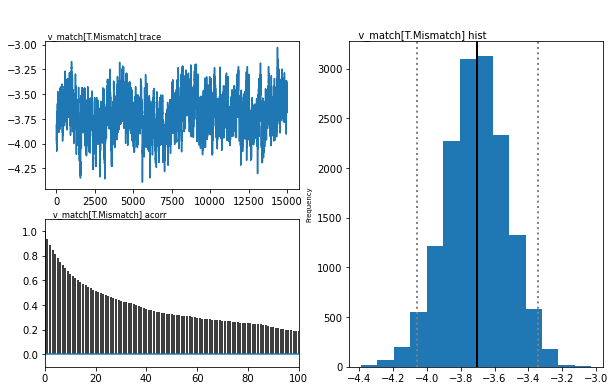

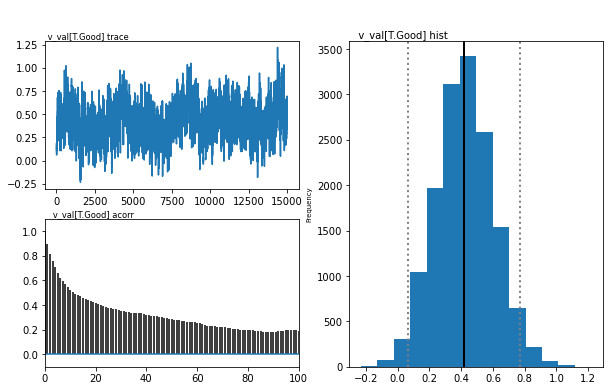

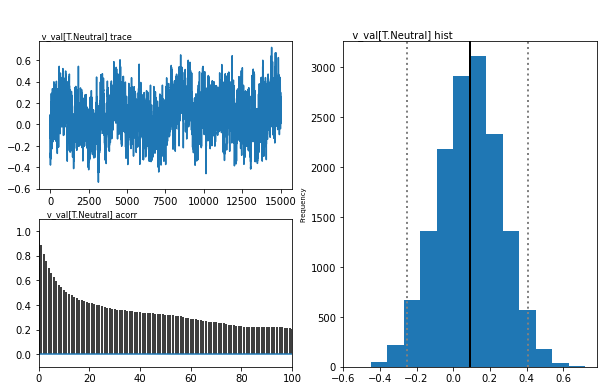

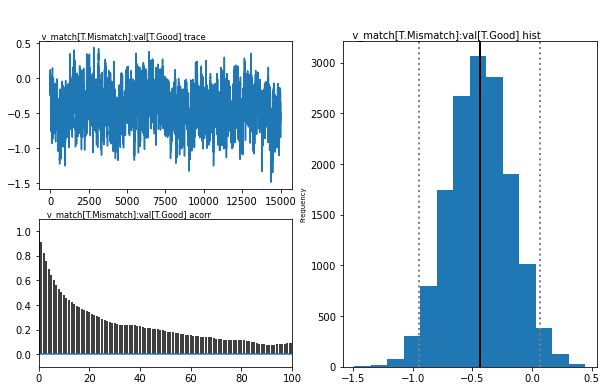

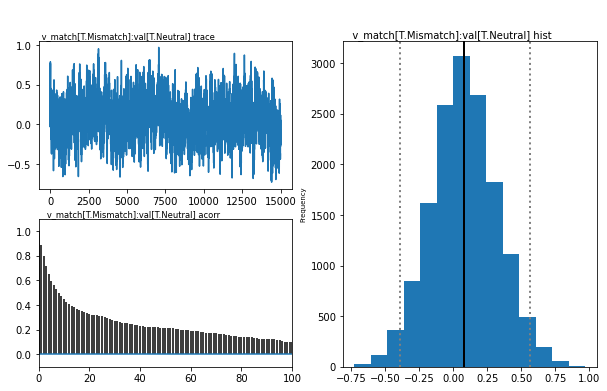

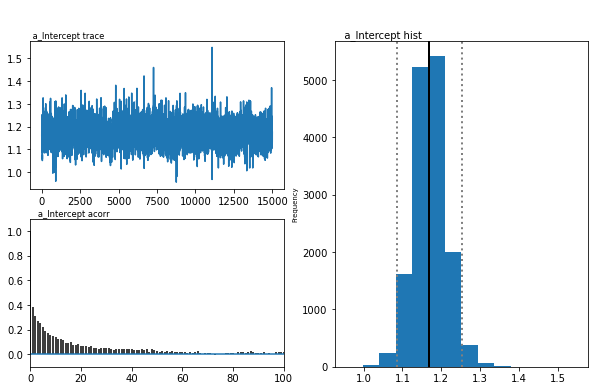

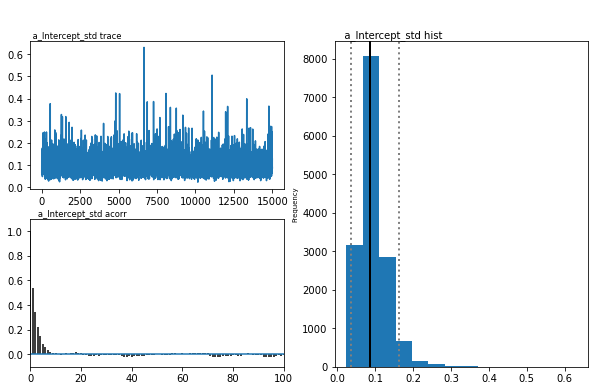

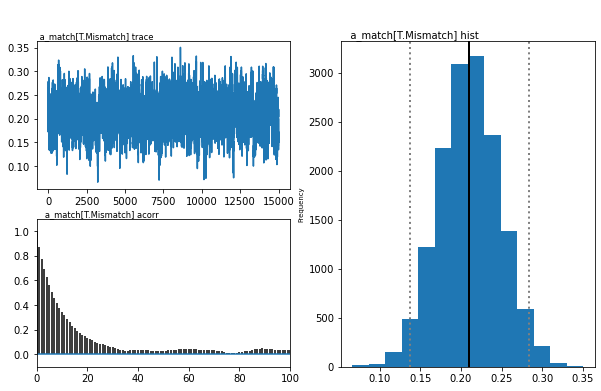

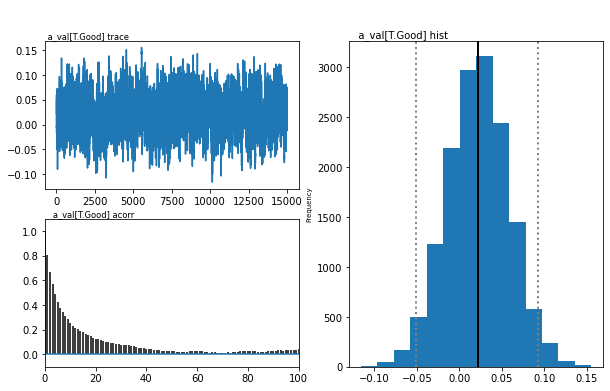

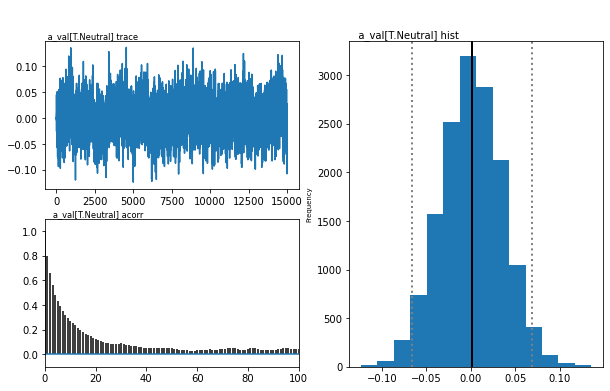

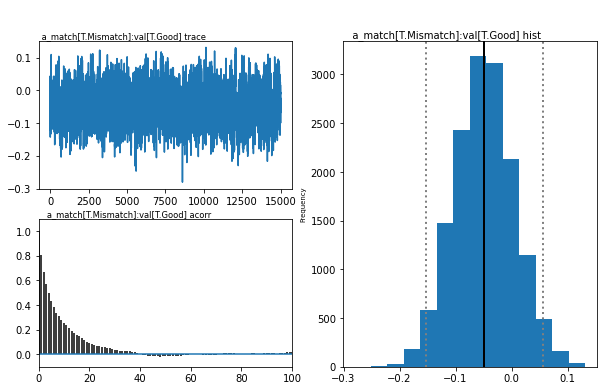

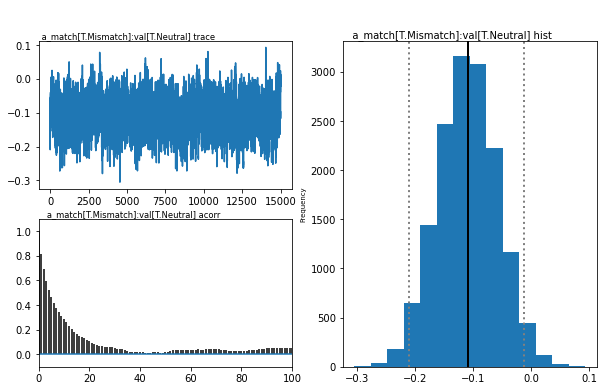

In [33]:
m_reg.plot_posteriors()

In [25]:
print("m_reg DIC: %f" % m_reg.dic) 

m_reg DIC: 761.899719


In [31]:
stats = m_reg.gen_stats()
stats

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
t,0.460852,0.0172888,0.428187,0.449998,0.460346,0.471378,0.496848,0.000292359
t_std,0.0499002,0.0167222,0.0292622,0.0386782,0.046498,0.0568448,0.0915157,0.000416273
t_subj.1001,0.441494,0.00746364,0.430154,0.437652,0.440793,0.444286,0.465118,0.000250703
t_subj.1003,0.399919,0.00468596,0.389123,0.397259,0.400288,0.402972,0.408057,0.000105611
t_subj.1015,0.437988,0.00792798,0.422167,0.432339,0.437927,0.444233,0.451561,0.000292877
t_subj.1021,0.489313,0.00588187,0.476631,0.485829,0.489496,0.493057,0.500454,0.000157323
t_subj.1031,0.419887,0.0115386,0.389056,0.41488,0.422264,0.427527,0.436301,0.000382978
t_subj.1033,0.504885,0.00489227,0.495341,0.501986,0.504841,0.507546,0.515275,0.000133783
t_subj.1034,0.496538,0.00718639,0.479283,0.492596,0.497661,0.501497,0.507893,0.000204827
t_subj.1035,0.513041,0.00546888,0.503275,0.509568,0.512821,0.516083,0.526321,0.000137693
